In [1]:
from utils import * #does not work as expected, don't know why
import scipy
from scipy.stats import norm

def mc_evol(y, level=0.99):
    """computes monte carlo evolution with confidence level bounds"""
    n = y.shape[0]
    nvec = np.arange(1, n+1)
    delta = np.cumsum(y) / nvec
    Var = np.zeros(n)
    Var[1:] =  (np.cumsum(y**2)[1:] - nvec[1:] * (delta[1:] ** 2)) / nvec[:n-1]; Var[0] = 0
    q = norm.interval(level)[1]
    i1 = delta - q * np.sqrt (Var / nvec)
    i2 = delta + q * np.sqrt (Var / nvec)
    #return {"delta": delta, "i1": i1, "i2": i2}
    return delta, i1, i2, nvec
    
def mc_evol_plot(evol, level, label=""):
    """plots mc evolution with confidence bounds """
    estimation, lower_bound, upper_bound, xx = evol
    plt.plot(xx, estimation, label=label)
    #plt.fill_between(xx, lower_bound, upper_bound, alpha=.2, label=str(100*level)+'% level confidence interval')
    plt.legend()

#compute transition matrices
    
def transition_matrices(data, number_of_actions, number_of_states):
    """Computes the transition matrices"""
    P = np.zeros((number_of_states, number_of_actions, number_of_states)) #initialize transitions array
    for s in range(number_of_states):
        for a in range(number_of_actions):
            d = data.next_state[(data.current_state == s) & (data.action == a+1)]
            freq = d.value_counts(normalize=True)
            for state in range(number_of_states):
                if state not in freq.index:
                    freq.loc[state] = 0
            P[s, a, :] = freq.sort_index()
    return P

def mixed_policy(pi, number_of_actions = 8, sim=False):
    pi = pi.astype(int)
    number_of_states = len(pi)
    Pi = np.zeros((number_of_states, number_of_actions))
    for s in range(number_of_states):
        Pi [s, pi[s] - 1 * sim] = 1 
    return Pi

#simulate learning
def get_next_state(current_state, action, data):
    return np.random.choice(data.next_state[(data.current_state == current_state) & (data.action == action)]) 

def get_reward(current_state, action, next_state, data):
   return np.random.choice(data.reward[(data.current_state == current_state) & (data.action == action) & (data.next_state == next_state)])

def select_action(state, Pi):
    prob = Pi[state]
    return np.random.choice(np.arange(1,8), p=prob)
def update_Q(Q, current_state, action, next_state, reward, gamma, alpha):
    action -= 1
    Q[current_state, action] = (1 - alpha) * Q[current_state, action] + alpha * (reward + gamma * Q[next_state].max())
    return Q

def update_policy(Q, pi, state, epsilon):
    a = Q[state].argmax()
    pi[state] = epsilon / 6
    pi[state, a] = 1-epsilon
    return pi

def sim_ql(Qinit, Pinit, gamma, alpha0, epsilon0, T, learn, data, decreasing_lrate=True):
    print("Starting QL simulation: \n initial policy: {} \n initial Q matrix: {} \n gamma = {}, epsilon0 = {}, alpha0 = {}, learn = {}".format(np.round(Pinit, 2), np.round(Qinit, 2), gamma, epsilon0, alpha0, learn ))
    pi = Pinit
    Q = Qinit
    alpha = alpha0
    epsilon = epsilon0
    number_of_states, number_of_actions = Q.shape
    number_of_visits = np.zeros((number_of_states, number_of_actions))
    Qmats = np.zeros((T+1, number_of_states, number_of_actions))
    Qmats[0] = Q
    current_state = data.current_state.iloc[0] #always start from the same initial state (does it matter?)
    list = []
    for t in range(T):
        action = select_action(current_state, pi)
        next_state = get_next_state(current_state, action, data)
        reward = get_reward(current_state, action, next_state, data)
        number_of_visits[current_state, action-1] += 1
        if decreasing_lrate: alpha = alpha0 / np.sqrt(number_of_visits[current_state, action-1])
        Q = update_Q(Q, current_state, action, next_state, reward, gamma, alpha)
        epsilon = epsilon0 #/ number_of_visits[current_state].sum()
        if learn: pi = update_policy(Q, pi, current_state, epsilon)
        Qmats[t+1] = Q
        list.append([t, current_state, action, next_state, reward, number_of_visits[current_state, action-1]])
        current_state = next_state
    return pd.DataFrame(list, columns=['time', 'current_state', 'action', 'next_state', 'reward', 'state-action number of visits']), Qmats


In [4]:
folder_name = 'naive3rdtest'
dir = "/Users/zakaryaelkhiyati/swimmers/i-eel/runs/bin/rep011/learn.bin"
dir1 = "/Users/zakaryaelkhiyati/swimmers/i-eel/runs/bin/"+ folder_name +"/learn.bin" # naive+
dir2 = "/Users/zakaryaelkhiyati/swimmers/i-eel/runs/bin/"+ folder_name +"/naive_snaps.bin" # naive+ with snapshots


In [5]:
file = open(dir2, 'r')
data = np.fromfile(file, dtype=float)
number_of_entries = int(data.shape[0] / 7) #7 corresponds to the number of stored data for each second
data = data.reshape(number_of_entries, 7)# each second has its own row now
header = ['time', 'action', 'current_position', 'current_state', 'next_state', 'next_position', 'reward'] #header row
df = pd.DataFrame(data, columns=header) # naive+ with snapshots ... why not use directly the load_binary file function? there's no Q, few other minor differences
df1, Qs = load_from_binary_file(dir1) #naive+
df1['time'] = df1['step'] // 2000 #add time column
df = df.convert_dtypes()
df1 = df1.convert_dtypes()
new_df = pd.merge(df, df1,  how='right', left_on=['time','action'], right_on = ['time','action'])#merge naive+ and naive+ with snaps for sanity checks

In [6]:
#sample_size = 100
time_step = 2
#import random
ind = np.arange(time_step, 10000 - time_step) #random.sample(range(time_step, 10000 - time_step), sample_size) #np.random.randint(time_step, 10000 - time_step, size=sample_size)
col2 = df1.state.iloc[ind].reset_index(drop=True)
col3 = df1.state.iloc[ind+1].reset_index(drop=True)
col1 = df1.state.iloc[ind-time_step].reset_index(drop=True)

#we have our columns let's create a dataframe table
frame = {'past':col1, 'present':col2, 'future':col3}
states_data = pd.DataFrame(frame)
#now let's try to build our contingency table

In [7]:
df1.state.value_counts()

5    4671
4    3363
3     674
1     620
0     462
2     210
Name: state, dtype: Int64

In [8]:
states_data
obs = states_data[states_data.present == 5]

In [9]:
obs

,past,present,future
0,5,5,5
1,5,5,5
2,5,5,4
4,5,5,4
19,4,5,4
...,...,...,...
9982,5,5,5
9983,5,5,5
9984,5,5,5
9985,5,5,4


In [10]:
def cor(u, v):
    x = u - u.mean()
    y = v - v.mean()
    return x.dot(y) / (np.linalg.norm(x) * np.linalg.norm(y))


In [11]:
np.corrcoef(obs.past.astype(float), obs.future.astype(float))

array([[1.        , 0.13484333],
       [0.13484333, 1.        ]])

In [12]:
cont_table = pd.crosstab(obs.past, obs.future, margins=True)

In [13]:
cont_table

future,1,2,3,4,5,All
past,,,,,,
0,0,0,0,0,1,1
1,1,0,0,0,17,18
2,0,0,0,5,16,21
3,0,0,0,7,7,14
4,0,4,1,98,472,575
5,0,3,0,284,3753,4040
All,1,7,1,394,4266,4669


In [14]:
chi2, p, dof, ex = scipy.stats.chi2_contingency(cont_table, correction=False)


In [15]:
print(" test statistic: {} \n p-value: {}\n degrees of freedom: {} \n 5% quantile: {}".format(chi2, p, dof, scipy.stats.chi2.ppf(0.05, df=dof)))

 test statistic: 384.2825984244381 
 p-value: 4.140402929830844e-63
 degrees of freedom: 30 
 5% quantile: 18.49266098195347


In [16]:
step_size = 2
list = []
for j in range(0, df1.shape[0] - step_size + 1):
    new_state = (df1.state[j], )
    for i in range(step_size-1):
        new_state = new_state + (df1.state[j+i+1],)
    list.append(new_state)

augmented_states = pd.Series(list)

In [18]:
ind = np.arange(1, augmented_states.shape[0] - 1)#random.sample(range(time_step, 10000 - time_step), sample_size) #np.random.randint(time_step, 10000 - time_step, size=sample_size)
col2 = augmented_states.iloc[ind].reset_index(drop=True)
col3 = augmented_states.iloc[ind+1].reset_index(drop=True)
col1 = augmented_states.iloc[ind-1].reset_index(drop=True)

#we have our columns let's create a dataframe table
frame = {'past':col1, 'present':col2, 'future':col3}
df3 = pd.DataFrame(frame)
#now let's try to build our contingency table


In [19]:
df3

,past,present,future
0,"(5, 5)","(5, 5)","(5, 5)"
1,"(5, 5)","(5, 5)","(5, 5)"
2,"(5, 5)","(5, 5)","(5, 4)"
3,"(5, 5)","(5, 4)","(4, 5)"
4,"(5, 4)","(4, 5)","(5, 4)"
...,...,...,...
9992,"(4, 4)","(4, 4)","(4, 4)"
9993,"(4, 4)","(4, 4)","(4, 4)"
9994,"(4, 4)","(4, 4)","(4, 3)"
9995,"(4, 4)","(4, 3)","(3, 0)"


In [20]:
df3.present.value_counts()

(5, 5)    4267
(4, 4)    2566
(5, 4)     394
(4, 5)     380
(1, 1)     370
(0, 0)     344
(3, 3)     328
(4, 3)     258
(3, 4)     223
(2, 2)     139
(1, 4)     139
(4, 1)     127
(3, 0)      68
(0, 3)      59
(3, 1)      50
(0, 1)      50
(1, 0)      45
(2, 4)      34
(1, 2)      33
(4, 2)      28
(1, 3)      27
(2, 1)      22
(2, 5)      14
(5, 2)       7
(0, 4)       7
(1, 5)       6
(4, 0)       4
(3, 2)       3
(3, 5)       2
(2, 3)       1
(5, 1)       1
(5, 3)       1
Name: present, dtype: int64

In [21]:
obs = df3[df3.present == list[10]]

In [22]:
cont_table = pd.crosstab(obs.past, obs.future, margins=False)

In [23]:
cont_table

future,"(4, 0)","(4, 1)","(4, 2)","(4, 3)","(4, 4)","(4, 5)"
past,,,,,,
"(0, 4)",0,0,0,0,2,0
"(1, 4)",0,12,0,5,74,6
"(2, 4)",0,1,1,4,20,0
"(3, 4)",0,14,3,31,101,1
"(4, 4)",4,61,8,114,1546,251
"(5, 4)",0,0,2,41,241,23


In [24]:
chi2, p, dof, ex = scipy.stats.chi2_contingency(cont_table, correction=False)
print(" test statistic: {} \n p-value: {}\n degrees of freedom: {} \n 5% quantile: {}".format(chi2, p, dof, scipy.stats.chi2.ppf(0.05, df=dof)))

 test statistic: 152.15054845972074 
 p-value: 3.3808614253980314e-20
 degrees of freedom: 25 
 5% quantile: 14.61140763948331


In [28]:
def chi2_stat(time_step, pr=False):
    ind = np.arange(time_step, 10000 - time_step) #random.sample(range(time_step, 10000 - time_step), sample_size) #np.random.randint(time_step, 10000 - time_step, size=sample_size)
    col2 = df1.state.iloc[ind].reset_index(drop=True)
    col3 = df1.state.iloc[ind+1].reset_index(drop=True)
    col1 = df1.state.iloc[ind-time_step].reset_index(drop=True)

    #we have our columns let's create a dataframe table
    frame = {'past':col1, 'present':col2, 'future':col3}
    states_data = pd.DataFrame(frame)
    obs = states_data[states_data.present == 5]
    cont_table = pd.crosstab(obs.past, obs.future, margins=True)
    chi2, p, dof, ex = scipy.stats.chi2_contingency(cont_table, correction=False)
    q = scipy.stats.chi2.ppf(0.0001, df=dof)

    if pr: print(" test statistic: {} \n p-value: {}\n degrees of freedom: {} \n 5% quantile: {}".format(chi2, p, dof, q))
    return p #cor(obs.past, obs.future)


In [26]:
nn =  np.arange(1, 1001)
yy = [chi2_stat(i) for i in nn]

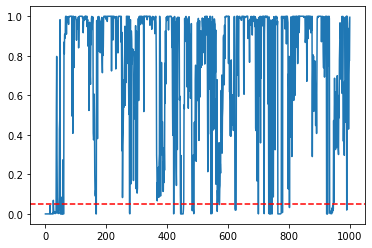

In [27]:
plt.plot(nn, np.abs(yy))

plt.axhline(0.05, linestyle='--', color='red')
#plt.yscale('log')
#plt.xlim(0,200)